<a href="https://colab.research.google.com/github/fatimasr68/Emotion-Prediction-DNN/blob/master/Classification/LSTM_Binary_Classifier_Arousal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow==2.0

In [2]:
pip install keras==2.3.1

# **Imports**

In [3]:
import keras
import keras.backend as K
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, LeakyReLU, Dropout
from keras import layers
from keras import optimizers, activations, regularizers, initializers
from keras.regularizers import L1L2
from keras.models import Model, Sequential
from keras.layers.recurrent import LSTM, GRU

from sklearn import metrics
from scipy import stats
import tensorflow as tf
import tensorflow.keras

from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import os


Using TensorFlow backend.


# **setup seed for Numpy**

In [4]:
seed = 8000

np.random.seed(seed)
np.random.RandomState(seed)
tf.random.set_seed(seed)

# **Parameters of DNN**

In [5]:
n_feature = 10000   #37130 

[n_in, n_hidden1, n_hidden2, n_hidden3, n_output] = [n_feature, 64, 34, 0, 1] #64, 34  6000

corruption_level = 0.0  # 0.6

n_epochs = 200
batch_size = 32
k_folds = 5

timesteps = 1

#Regularizer Parameters

l1 = 1e-5  # 0   
l2 = 1e-5  # 0  

# **Load Data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
X = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/sub-000_feature.csv', header=None)
Y = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/aro_score.csv', header=None)

# **Data 2**

In [8]:
'''
data = sio.loadmat('/content/drive/My Drive/Colab Notebooks/emt_valence_sample.mat')
train_x_ =  data["train_x"]
train_y_ = data["train_y"]
test_x_  = data["test_x"]
test_y_  = data["test_y"]

X = np.vstack([train_x_, test_x_])   #total_x
Y = np.hstack([train_y_, test_y_])   #total_y
Y = Y.T   #/ 10
Y = Y.ravel()

print('X: ', X.shape)
print('Y: ', Y.shape)
'''

'\ndata = sio.loadmat(\'/content/drive/My Drive/Colab Notebooks/emt_valence_sample.mat\')\ntrain_x_ =  data["train_x"]\ntrain_y_ = data["train_y"]\ntest_x_  = data["test_x"]\ntest_y_  = data["test_y"]\n\nX = np.vstack([train_x_, test_x_])   #total_x\nY = np.hstack([train_y_, test_y_])   #total_y\nY = Y.T   #/ 10\nY = Y.ravel()\n\nprint(\'X: \', X.shape)\nprint(\'Y: \', Y.shape)\n'

## **X & Y**

In [9]:
X = X.to_numpy() 
Y = Y.to_numpy() 

Y = Y.ravel()


## **Y Classify**

In [10]:
Y[Y <= 4.99] = 0
Y[Y > 4.99] = 1

Y = np.int_(Y)
print(Y)

[0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0
 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0
 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 1]


## **Scale**

In [11]:
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler

X = MinMaxScaler().fit_transform(X)


## **Denoising**

In [12]:
def get_corrupted_input(input, corruption_level):
  cr = K.random_binomial(shape= input.shape, p= 1-corruption_level, seed=123) * input
  
  return cr


X = get_corrupted_input(X, corruption_level).numpy()

## **Decomposition**

In [13]:
from sklearn.decomposition import PCA, LatentDirichletAllocation

'''
pca = PCA(n_components = n_feature, svd_solver='full')   # 84, 0.08
#lda = LatentDirichletAllocation(n_components = 90, random_state=0)
pca.fit(X)

X = pca.transform(X)
'''

"\npca = PCA(n_components = n_feature, svd_solver='full')   # 84, 0.08\n#lda = LatentDirichletAllocation(n_components = 90, random_state=0)\npca.fit(X)\n\nX = pca.transform(X)\n"

## **Feature Selection**

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

X = pd.DataFrame(X)  

chi_selector = SelectKBest(f_classif, k = n_feature)
chi_selector.fit(X, Y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:, chi_support]

X = chi_feature.to_numpy()


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [    0     1     2 ... 18072 19272 20444] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [15]:
'''
from skfeature.function.similarity_based import fisher_score

idx = fisher_score.fisher_score(X, Y, mode='rank')
print(idx)

X = X[:, idx[0:n_feature]]
'''

"\nfrom skfeature.function.similarity_based import fisher_score\n\nidx = fisher_score.fisher_score(X, Y, mode='rank')\nprint(idx)\n\nX = X[:, idx[0:n_feature]]\n"

In [16]:
#pip install skfeature-chappers

# **Custom Metrics**

In [17]:
import keras.backend as K

def mean_pred(y_true, y_pred):
  return K.mean(y_pred)


def STD_pred(y_true, y_pred):
  return K.std(y_pred)


# **Callbacks**

In [18]:
class prediction_history(keras.callbacks.Callback):
    def __init__(self):
        self.pred_train = []
        self.pred_test  = []
        self.epochs_ = 0


    def on_epoch_end(self, epoch, logs={}):
        self.epochs_ = self.epochs_ + 1
        prediction_train = model.predict(x_tr)
        prediction_test = model.predict(x_val)
        self.pred_train.append(prediction_train)
        self.pred_test.append(prediction_test)
        

        ACC_test = metrics.accuracy_score(y_val, prediction_test.round())

  
        if (self.epochs_ > 100 and ACC_test == 1):
          self.model.stop_training = True
          print("STOP!")

# **DNN**

## **Create & Compile Model**

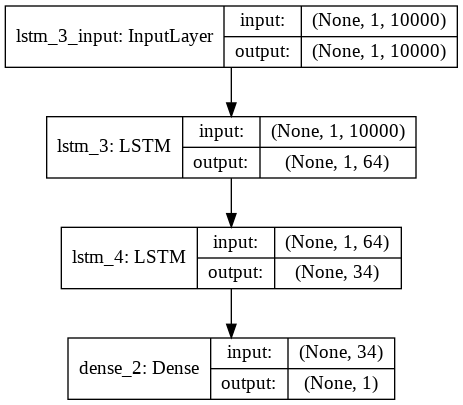

In [19]:
#checkpoint_filepath = '/tmp/checkpoint'

def create_model():

  model = Sequential()

  model.add(LSTM(units= n_hidden1,  
                dropout= 0.2,  # cr=0.7 f=15000 -->  0.0:98+03  0.1:95    0.5:98+0.03
                recurrent_dropout= 0.5,  #0.7
                activation = 'relu',
                recurrent_activation = 'sigmoid',

                bias_regularizer = L1L2(l1= l1, l2= l2),
                kernel_regularizer = L1L2(l1= l1, l2= l2),
                activity_regularizer = L1L2(l1= l1, l2= l2),

                kernel_initializer = initializers.he_normal(),
                return_sequences= True,
                input_shape=(timesteps, n_in)))  


  #model.add(Dropout(0.1))

  model.add(LSTM(units= n_hidden2,  
                dropout= 0.2,  # 0.1,..., 0.5
                recurrent_dropout= 0.5,  #0.7
                activation = 'sigmoid',
                recurrent_activation = 'sigmoid',

                bias_regularizer = L1L2(l1= l1, l2= l2),
                kernel_regularizer = L1L2(l1= l1, l2= l2),
                activity_regularizer = L1L2(l1= l1, l2= l2),
                 
                #kernel_initializer = initializers.he_uniform(),
                kernel_initializer = initializers.orthogonal(),
                return_sequences= False))


  
  model.add(Dense(units= 1, 
                  activation= 'sigmoid'))


  '''
  model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      verbose= 1,
      mode='max',
      save_best_only=True)
  '''


  # Adamax(learning_rate= 0.0001) 
  # RMSprop(learning_rate= 0.0001)   

  model.compile(optimizer= optimizers.Adam(learning_rate= 0.0001), 
                loss= keras.losses.binary_crossentropy,
                metrics= ['accuracy'])
  


  return model


model = create_model()
#model.summary()

plot_model(create_model(), show_shapes= True)

## **Train model with K-fold CV**

In [20]:
CV_history = [] 

val_data_x = []
val_data_y = []

train_data_x = []
train_data_y = []

pred_val_tr = []
pred_val_ts = []

ACCs  = []
conf_mat = []


checkpoint_filepath = '/tmp/checkpoint'



fold_no = 0 
#StratifiedKFold
for train_index, val_index in StratifiedKFold(n_splits= k_folds, shuffle= True, random_state= seed).split(X, Y):

  x_tr, x_val = X[train_index], X[val_index]
  y_tr, y_val = Y[train_index], Y[val_index]

  fold_no += 1

  print('-------------------------------------------------------------------------------')
  print('Training for fold ', fold_no)
  print('-------------------------------------------------------------------------------')


  train_data_x.append(X[train_index])
  train_data_y.append(Y[train_index])
  val_data_x.append(X[val_index])
  val_data_y.append(Y[val_index])

  x_tr  = np.reshape(x_tr , (x_tr.shape[0] , 1, x_tr.shape[1] ))
  x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1])) 

  model = None
  model = create_model()


  model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      verbose= 1,
      mode='max',
      save_best_only=True)
  

  cbk = prediction_history()


  results = model.fit(x_tr, y_tr, epochs= n_epochs,
                          batch_size= batch_size,
                          callbacks = [cbk, model_checkpoint_callback],  #_callback(), model_checkpoint_callback
                          verbose = 2,
                          validation_data = [x_val, y_val]
                        )


  # Updating to use the best model
  model.load_weights(checkpoint_filepath)



  pred_val_tr.append(model.predict_classes(x_tr))
  pred_val_ts.append(model.predict_classes(x_val))


  scores = model.evaluate(x_val, y_val)
  print("%s: %.2f" % (model.metrics_names[1], scores[1] ))   #ACC
  ACCs.append(scores[1])


  CV_history.append(results)
  print("======="*12, end="\n\n\n")



-------------------------------------------------------------------------------
Training for fold  1
-------------------------------------------------------------------------------
Train on 72 samples, validate on 18 samples
Epoch 1/200
 - 1s - loss: 1.0220 - accuracy: 0.5000 - val_loss: 0.9966 - val_accuracy: 0.5556

Epoch 00001: val_accuracy improved from -inf to 0.55556, saving model to /tmp/checkpoint
Epoch 2/200
 - 0s - loss: 1.0073 - accuracy: 0.5000 - val_loss: 0.9945 - val_accuracy: 0.5556

Epoch 00002: val_accuracy did not improve from 0.55556
Epoch 3/200
 - 0s - loss: 1.0013 - accuracy: 0.5278 - val_loss: 0.9926 - val_accuracy: 0.6667

Epoch 00003: val_accuracy improved from 0.55556 to 0.66667, saving model to /tmp/checkpoint
Epoch 4/200
 - 0s - loss: 0.9963 - accuracy: 0.5972 - val_loss: 0.9879 - val_accuracy: 0.6667

Epoch 00004: val_accuracy did not improve from 0.66667
Epoch 5/200
 - 0s - loss: 0.9925 - accuracy: 0.5556 - val_loss: 0.9837 - val_accuracy: 0.6111

Epoch 000

# **Evaluate**

## **Evaluate Model**

In [21]:
# == Provide average scores ==
print('-----------------------------' * 4)
print('Results per fold: ')
for i in range(0, len(ACCs)):
  print('-----------------------------' * 4)
  print(f'Fold {i+1} - ACC: {ACCs[i]}')
print('-----------------------------' * 4)
print('Average scores for all folds:')

print("\nACC:  %.0f (+/-) %.0f" % (np.mean(ACCs)*100 , np.std(ACCs)*100 ))


print('----------------------------' * 4)


tr_Acc = np.mean((
        CV_history[0].history['accuracy'][-1],
        CV_history[1].history['accuracy'][-1],
        CV_history[2].history['accuracy'][-1],
        CV_history[3].history['accuracy'][-1],
        CV_history[4].history['accuracy'][-1]))

print('----------------------------' * 4)

print("\nTrain ACC:   %.0f (+/-) %.0f" % (np.mean(tr_Acc)*100  , np.std(tr_Acc)*100  ))

--------------------------------------------------------------------------------------------------------------------
Results per fold: 
--------------------------------------------------------------------------------------------------------------------
Fold 1 - ACC: 0.7777777910232544
--------------------------------------------------------------------------------------------------------------------
Fold 2 - ACC: 0.8888888955116272
--------------------------------------------------------------------------------------------------------------------
Fold 3 - ACC: 0.9444444179534912
--------------------------------------------------------------------------------------------------------------------
Fold 4 - ACC: 0.8333333134651184
--------------------------------------------------------------------------------------------------------------------
Fold 5 - ACC: 0.9444444179534912
------------------------------------------------------------------------------------------------------------------

 81 (+/-) 8

In [22]:
print(ACCs)

[0.7777777910232544, 0.8888888955116272, 0.9444444179534912, 0.8333333134651184, 0.9444444179534912]


In [23]:
#f_Classif Aro

CCS0=[0.7777777910232544, 0.8888888955116272, 0.9444444179534912, 0.8888888955116272, 0.9444444179534912]
CCs1=[0.6666666865348816, 0.7222222089767456, 0.7222222089767456, 0.7222222089767456, 0.7777777910232544]
CCs2=[0.9444444179534912, 0.8333333134651184, 0.9444444179534912, 0.7222222089767456, 0.8888888955116272]
CCs3=[0.8888888955116272, 0.7222222089767456, 0.8888888955116272, 0.8333333134651184, 0.8888888955116272]
CCs4=[0.7777777910232544, 0.9444444179534912, 0.9444444179534912, 0.7777777910232544, 0.8333333134651184]
CCs5=[0.7222222089767456, 0.6666666865348816, 0.7777777910232544, 0.8333333134651184, 0.6666666865348816]
CCs6=[0.8333333134651184, 0.7777777910232544, 1.0, 0.7777777910232544, 0.7222222089767456]
CCs7=[0.8333333134651184, 0.9444444179534912, 0.8888888955116272, 0.7777777910232544, 0.8333333134651184]
CCs8=[0.6155555820465088, 0.7222222089767456, 0.8333333134651184, 0.7222222089767456, 0.6111111044883728]
CCs9=[0.7222222089767456, 0.7222222089767456, 0.7777777910232544, 0.6111111044883728, 0.6111111044883728]
CCs10=[0.7777777910232544, 0.8888888955116272, 0.9444444179534912, 0.8333333134651184, 0.9444444179534912]
CCs11=[0.8888888955116272, 0.8888888955116272, 0.8888888955116272, 0.8333333134651184, 0.8333333134651184]
CCs12=[0.7222222089767456, 0.7222222089767456, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816]
CCs13=[0.8333333134651184, 0.8888888955116272, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544]
CCs14=[0.8333333134651184, 0.8333333134651184, 0.9444444179534912, 0.8888888955116272, 0.9444444179534912]
CCs15=[0.8333333134651184, 0.6666666865348816, 0.6666666865348816, 0.7777777910232544, 0.8333333134651184]
CCs16=[0.8333333134651184, 1.0, 0.8333333134651184, 0.8888888955116272, 0.8333333134651184]
CCs17=[0.9444444179534912, 0.9444444179534912, 0.8333333134651184, 0.8888888955116272, 0.8888888955116272]
CCs18=[0.8333333134651184, 0.8333333134651184, 0.9444444179534912, 0.7222222089767456, 0.8888888955116272]


#f_Classif Val
CCs0=[0.8888888955116272, 0.7777777910232544, 0.6666666865348816, 0.8333333134651184, 0.7222222089767456]
CCs1=[0.8333333134651184, 0.8333333134651184, 0.7222222089767456, 0.7777777910232544, 0.7222222089767456]
CCs2=[0.7222222089767456, 0.7777777910232544, 0.8333333134651184, 0.6666666865348816, 0.6666666865348816]
CCs3=[0.8333333134651184, 0.8333333134651184, 0.8333333134651184, 0.9444444179534912, 0.7222222089767456]
CCs4=[0.8333333134651184, 0.7777777910232544, 0.8333333134651184, 0.6666666865348816, 0.8333333134651184]
CCs5=[0.7777777910232544, 0.8888888955116272, 1.0, 0.6111111044883728, 0.7222222089767456]
CCs6=[0.8333333134651184, 0.8888888955116272, 0.8888888955116272, 0.8333333134651184, 0.8333333134651184]
CCs7=[0.8888888955116272, 0.8333333134651184, 0.8888888955116272, 0.8888888955116272, 0.7222222089767456]
CCs8=[0.7777777910232544, 0.7222222089767456, 0.7777777910232544, 0.7777777910232544, 0.6111111044883728]
CCs9=[0.8888888955116272, 0.8888888955116272, 0.7777777910232544, 0.7777777910232544, 0.7222222089767456]
CCs10=[0.8888888955116272, 0.7777777910232544, 0.8888888955116272, 0.8888888955116272, 0.7222222089767456]
CCs11=[0.7222222089767456, 0.8888888955116272, 0.8888888955116272, 0.7777777910232544, 0.8333333134651184]
CCs12=[0.8888888955116272, 0.7777777910232544, 0.7222222089767456, 0.6666666865348816, 0.6666666865348816]
CCs13=[0.9444444179534912, 0.9444444179534912, 0.7777777910232544, 0.8333333134651184, 0.7777777910232544]
CCs14=[0.8888888955116272, 0.8888888955116272, 0.7777777910232544, 0.8333333134651184, 0.8333333134651184]
CCs15=[0.8333333134651184, 0.8888888955116272, 1.0, 0.7222222089767456, 0.6666666865348816]
CCs16=[0.9444444179534912, 0.7222222089767456, 0.9444444179534912, 0.8888888955116272, 0.6666666865348816]
CCs17=[0.8888888955116272, 0.8888888955116272, 0.7222222089767456, 0.8333333134651184, 0.8333333134651184]
CCs18=[0.7777777910232544, 0.8333333134651184, 0.7777777910232544, 0.7777777910232544, 0.8333333134651184]

In [24]:
np.mean(CCs10)

0.8333333373069763

ACC:  0.83 (+/-) 0.05, [64, 34],  epoch:200

In [25]:
# Aro 10000  0.0, 0.2

CC0=[0.7777777910232544, 0.8888888955116272, 0.8888888955116272, 0.8888888955116272, 0.9444444179534912]
CC1=[0.6666666865348816, 0.7222222089767456, 0.7222222089767456, 0.6666666865348816, 0.7222222089767456]
CC2=[0.9444444179534912, 0.8333333134651184, 0.9444444179534912, 0.7222222089767456, 0.8333333134651184]
CC3=[0.7777777910232544, 0.6666666865348816, 0.8888888955116272, 0.8333333134651184, 0.8888888955116272]
CC4=[0.7777777910232544, 0.9444444179534912, 0.9444444179534912, 0.7777777910232544, 0.8333333134651184]
CC5=[0.7222222089767456, 0.6666666865348816, 0.7777777910232544, 0.7222222089767456, 0.7777777910232544]
CC6=[0.7777777910232544, 0.7777777910232544, 1.0, 0.7777777910232544, 0.7222222089767456]
CC7=[0.8333333134651184, 0.9444444179534912, 0.8888888955116272, 0.6666666865348816, 0.7777777910232544]
CC8=[0.6111111044883728, 0.7222222089767456, 0.8333333134651184, 0.6111111044883728, 0.6666666865348816]
CC9=[0.6666666865348816, 0.7777777910232544, 0.7222222089767456, 0.6111111044883728, 0.6111111044883728]
CC10=[0.7222222089767456, 0.9444444179534912, 0.9444444179534912, 0.8888888955116272, 0.9444444179534912]
CC11=[0.8333333134651184, 0.8888888955116272, 0.8888888955116272, 0.8888888955116272, 0.8333333134651184]
CC12=[0.7222222089767456, 0.7222222089767456, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816]
CC13=[0.8333333134651184, 0.8333333134651184, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544]
CC14=[0.8333333134651184, 0.8333333134651184, 0.9444444179534912, 0.8888888955116272, 0.9444444179534912]
CC15=[0.8888888955116272, 0.6666666865348816, 0.6666666865348816, 0.7777777910232544, 0.6666666865348816]
CC16=[0.8333333134651184, 0.9444444179534912, 0.8333333134651184, 0.8888888955116272, 0.7777777910232544]
CC17=[0.9444444179534912, 0.9444444179534912, 0.8333333134651184, 0.8888888955116272, 0.8333333134651184]
CC18=[0.8333333134651184, 0.8333333134651184, 0.9444444179534912, 0.6666666865348816, 0.8888888955116272]


# Aro 10000  0.2, 0.2

CC0=[0.8333333134651184, 0.8888888955116272, 0.8888888955116272, 0.8333333134651184, 0.9444444179534912]
CC1=[0.7222222089767456, 0.7222222089767456, 0.7222222089767456, 0.6666666865348816, 0.7222222089767456]
CC2=[0.9444444179534912, 0.8333333134651184, 0.9444444179534912, 0.7777777910232544, 0.8888888955116272]
CC3=[0.8333333134651184, 0.7222222089767456, 0.8888888955116272, 0.8333333134651184, 0.8888888955116272]
CC4=[0.7777777910232544, 0.9444444179534912, 0.9444444179534912, 0.7777777910232544, 0.8333333134651184]
CC5=[0.7222222089767456, 0.6666666865348816, 0.8333333134651184, 0.7222222089767456, 0.6666666865348816]
CC6=[0.8333333134651184, 0.7777777910232544, 1.0, 0.7777777910232544, 0.7222222089767456]
CC7=[0.8333333134651184, 0.9444444179534912, 0.8888888955116272, 0.7222222089767456, 0.8333333134651184]
CC8=[0.5555555820465088, 0.6666666865348816, 0.8333333134651184, 0.6111111044883728, 0.5555555820465088]
CC9=[0.6666666865348816, 0.7222222089767456, 0.7777777910232544, 0.6111111044883728, 0.6111111044883728]
CC10=[0.7222222089767456, 0.8888888955116272, 0.9444444179534912, 0.8888888955116272, 0.9444444179534912]
CC11=[0.8333333134651184, 0.8333333134651184, 0.8333333134651184, 0.8333333134651184, 0.8333333134651184]
CC12=[0.7222222089767456, 0.7222222089767456, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816]
CC13=[0.7222222089767456, 0.8333333134651184, 0.8333333134651184, 0.7777777910232544, 0.7777777910232544]
CC14=[0.8333333134651184, 0.8333333134651184, 0.9444444179534912, 0.8888888955116272, 0.9444444179534912]
CC15=[0.8333333134651184, 0.6666666865348816, 0.6666666865348816, 0.7222222089767456, 0.7222222089767456]
CC16=[0.7777777910232544, 0.9444444179534912, 0.8333333134651184, 0.8888888955116272, 0.8333333134651184]
CC17=[0.9444444179534912, 0.9444444179534912, 0.8333333134651184, 0.8888888955116272, 0.8888888955116272]
CC18=[0.8333333134651184, 0.8333333134651184, 0.9444444179534912, 0.7222222089767456, 0.8888888955116272]

In [26]:
# Valenc

CC0=[0.7777777910232544, 0.8888888955116272, 0.6111111044883728, 0.7222222089767456, 0.7222222089767456]
CC1=[0.7777777910232544, 0.7777777910232544, 0.6111111044883728, 0.7222222089767456, 0.5555555820465088]
CC2=[0.7222222089767456, 0.8333333134651184, 0.7777777910232544, 0.6666666865348816, 0.6666666865348816]


CC0=[0.7777777910232544, 0.6111111044883728, 0.6666666865348816, 0.7222222089767456, 0.6666666865348816]
CC1=[0.7777777910232544, 0.7777777910232544, 0.6111111044883728, 0.6666666865348816, 0.6111111044883728]
CC2=[0.7777777910232544, 0.7222222089767456, 0.7777777910232544, 0.6666666865348816, 0.6666666865348816]
CC3=[0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.8888888955116272, 0.6111111044883728]
CC4=[0.5555555820465088, 0.5555555820465088, 0.6666666865348816, 0.5555555820465088, 0.6111111044883728]
CC5=[0.6666666865348816, 0.6666666865348816, 0.8333333134651184, 0.5, 0.5555555820465088]
CC6=[0.7222222089767456, 0.7777777910232544, 0.7222222089767456, 0.7222222089767456, 0.6111111044883728]
CC7=[0.7777777910232544, 0.6666666865348816, 0.7222222089767456, 0.8333333134651184, 0.6111111044883728]
CC8=[0.7222222089767456, 0.6111111044883728, 0.7222222089767456, 0.6666666865348816, 0.5555555820465088]
CC9=[0.7777777910232544, 0.8888888955116272, 0.6666666865348816, 0.6666666865348816, 0.7222222089767456]
CC10=[0.8333333134651184, 0.6111111044883728, 0.6111111044883728, 0.7777777910232544, 0.6111111044883728]
CC11=[0.6666666865348816, 0.7222222089767456, 0.6666666865348816, 0.7222222089767456, 0.7222222089767456]
CC12=[0.7777777910232544, 0.6111111044883728, 0.6666666865348816, 0.5555555820465088, 0.5]
CC13=[0.7777777910232544, 0.7222222089767456, 0.6111111044883728, 0.7222222089767456, 0.6111111044883728]
CC14=[0.6111111044883728, 0.6111111044883728, 0.6666666865348816, 0.5555555820465088, 0.6111111044883728]
CC15=[0.7777777910232544, 0.7222222089767456, 0.7777777910232544, 0.7222222089767456, 0.5555555820465088]
CC16=[0.8333333134651184, 0.6111111044883728, 0.8333333134651184, 0.7777777910232544, 0.6666666865348816]
CC17=[0.7777777910232544, 0.6666666865348816, 0.6111111044883728, 0.7222222089767456, 0.6666666865348816]
CC18=[0.6666666865348816, 0.7777777910232544, 0.7777777910232544, 0.7222222089767456, 0.7222222089767456]

## **Box Plot**

In [27]:
labels = ['LSTM 1']
boxprops = dict(linestyle='-', linewidth=3, color='#00BFFF')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12, linestyle='none')
medianprops = dict(linestyle='-.', linewidth=2.5, color='#00BFFF')
meanpointprops = dict(marker='D', markeredgecolor='red', markerfacecolor='yellow', markersize=7)
meanlineprops = dict(linestyle='-', linewidth=2, color='orange')

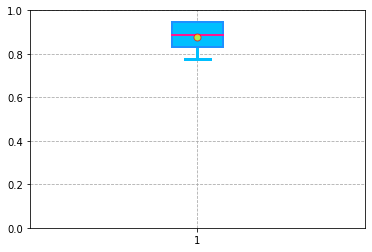

In [28]:
## to get fill color
bp = plt.boxplot(ACCs, 
                 patch_artist = True,
                 showmeans = True,
                 meanprops = meanpointprops,
                 )

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#1E90FF', linewidth=2)
    # change fill color
    box.set( facecolor = '#00BFFF' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#00BFFF', linewidth=3)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#00BFFF', linewidth=3)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#FF1493', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#9c0', alpha=0.5)

for mean in bp['means']:
    mean.set(marker='o', color='#000', alpha=0.7)

plt.ylim(0, 1)
plt.grid(color='#aaa', ls = '--')
plt.show()    

## **Accuracy of Folds**

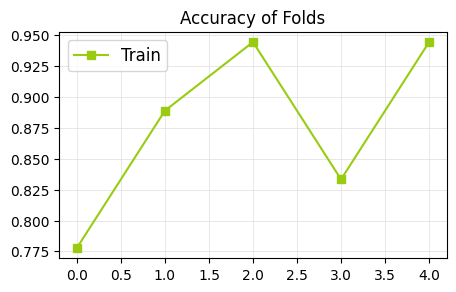

In [29]:
plt.figure(figsize=(5, 3), dpi=100)
ax = plt.plot(ACCs, label='Train', marker='s', color='#99cc11')


plt.title('Accuracy of Folds')
#plt.axis([0, k_folds-1, 0, 0.3])
#plt.ylim(0, 1)
xtickslocs = np.arange(1, 5, step=1)
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **Loss**

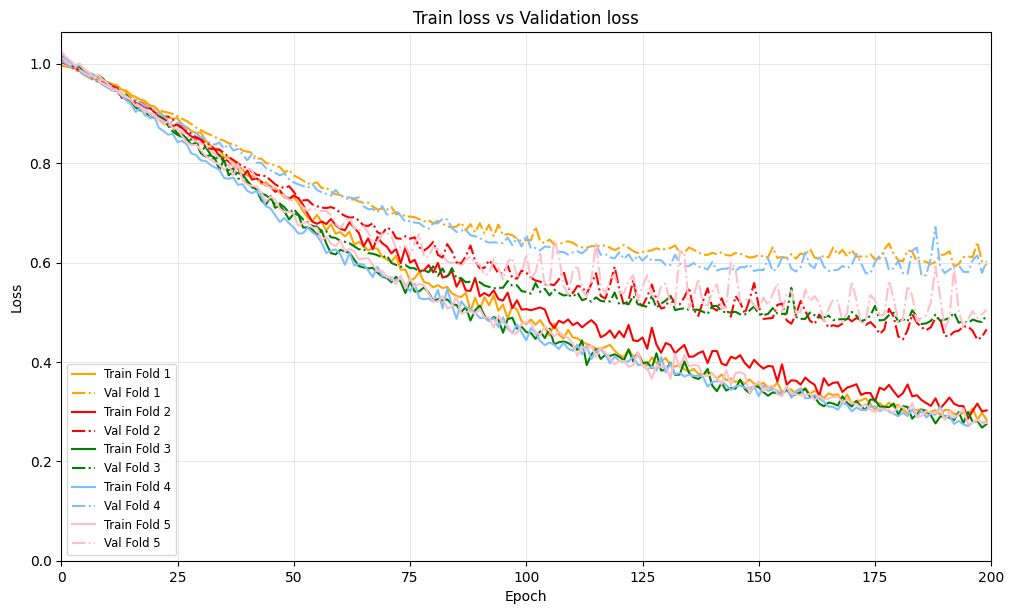

In [30]:
plt.figure(figsize=(12, 7), dpi=100)
plt.title('Train loss vs Validation loss')

plt.plot(CV_history[0].history['loss'], label='Train Fold 1', color='orange')
plt.plot(CV_history[0].history['val_loss'], label='Val Fold 1', color='orange', linestyle = "dashdot")

plt.plot(CV_history[1].history['loss'], label='Train Fold 2', color='red', )
plt.plot(CV_history[1].history['val_loss'], label='Val Fold 2', color='red', linestyle = "dashdot")

plt.plot(CV_history[2].history['loss'], label='Train Fold 3', color='green', )
plt.plot(CV_history[2].history['val_loss'], label='Val Fold 3', color='green', linestyle = "dashdot")

plt.plot(CV_history[3].history['loss'], label='Train Fold 4', color='#80bfff', )
plt.plot(CV_history[3].history['val_loss'], label='Val Fold 4', color='#80bfff', linestyle = "dashdot")

plt.plot(CV_history[4].history['loss'], label='Train Fold 5', color='#FFC0CB', )
plt.plot(CV_history[4].history['val_loss'], label='Val Fold 5', color='#FFC0CB', linestyle = "dashdot")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 200)
plt.ylim(0, )
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **Accuracy**

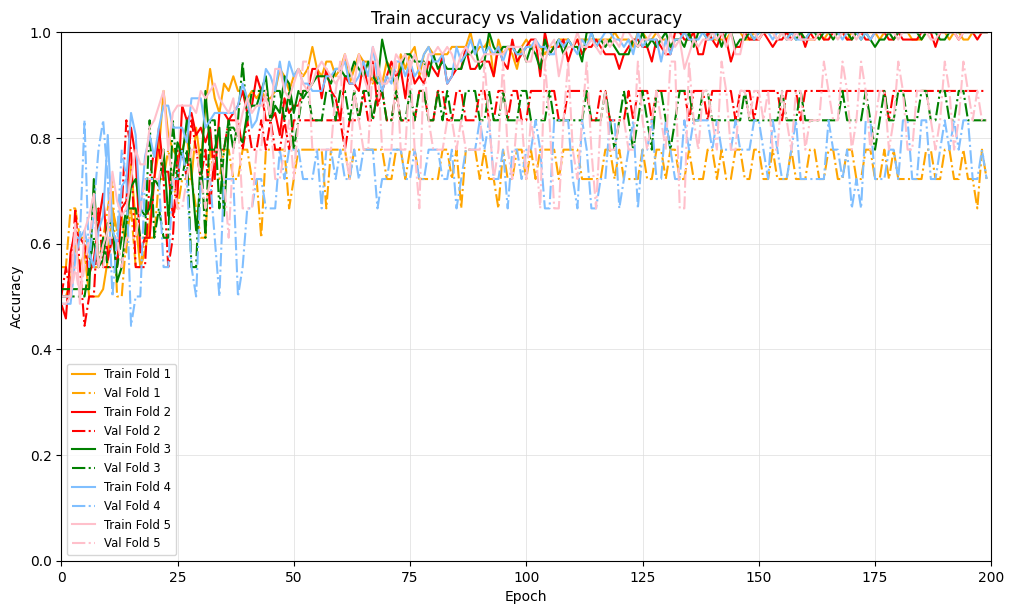

In [31]:
plt.figure(figsize=(12, 7), dpi=100)
plt.title('Train accuracy vs Validation accuracy')

plt.plot(CV_history[0].history['accuracy'], label='Train Fold 1', color='orange')
plt.plot(CV_history[0].history['val_accuracy'], label='Val Fold 1', color='orange', linestyle = "dashdot")

plt.plot(CV_history[1].history['accuracy'], label='Train Fold 2', color='red', )
plt.plot(CV_history[1].history['val_accuracy'], label='Val Fold 2', color='red', linestyle = "dashdot")

plt.plot(CV_history[2].history['accuracy'], label='Train Fold 3', color='green', )
plt.plot(CV_history[2].history['val_accuracy'], label='Val Fold 3', color='green', linestyle = "dashdot")

plt.plot(CV_history[3].history['accuracy'], label='Train Fold 4', color='#80bfff', )
plt.plot(CV_history[3].history['val_accuracy'], label='Val Fold 4', color='#80bfff', linestyle = "dashdot")

plt.plot(CV_history[4].history['accuracy'], label='Train Fold 5', color='#FFC0CB', )
plt.plot(CV_history[4].history['val_accuracy'], label='Val Fold 5', color='#FFC0CB', linestyle = "dashdot")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

In [32]:
# 10000 Aro

mean = np.mean([80,63,72,79,78,52,79,69,40,54,78,76,50,76,80,58,78,76,77])
std  = np.std ([80,63,72,79,78,52,79,69,40,54,78,76,50,76,80,58,78,76,77])
print(mean , '+/-' , std)

69.21052631578948 +/- 12.089921628619004


In [33]:
# 10000 Val

mean = np.mean([71,66,56,70,67,66,78,74,63,76,70,72,56,79,80,71,73,74,70])
std  = np.std ([71,66,56,70,67,66,78,74,63,76,70,72,56,79,80,71,73,74,70])
print(mean , '+/-' , std)

70.10526315789474 +/- 6.528437685615024


In [34]:
mean = np.mean([97,81,99,97,99,99,98,100,96,99,100,99,94,98,99,100,99,99,99])
std  = np.std ([97,81,99,97,99,99,98,100,96,99,100,99,94,98,99,100,99,99,99])
print(mean , '+/-' , std)

97.47368421052632 +/- 4.146887495493098


In [35]:
# All Arousal

mean = np.mean([63,58,67,59,64,67,62,66,57,54,71,52,59,61,61,62,68,69,59])
std  = np.std ([63,58,67,59,64,67,62,66,57,54,71,52,59,61,61,62,68,69,59])
print(mean , '+/-' , std)

62.05263157894737 +/- 4.978624669635987


In [36]:
# All Valence

mean = np.mean([60,60,61,64,50,49,57,64,54,61,51,53,46,56,47,59,62,59,59])
std  = np.std ([60,60,61,64,50,49,57,64,54,61,51,53,46,56,47,59,62,59,59])
print(mean , '+/-' , std)

56.421052631578945 +/- 5.499433362903799


In [37]:
mean = np.mean([72,67,67,66,72,72,70,65,60,70,69,69,63,69,65,76,69,63,66])
std  = np.std ([72,67,67,66,72,72,70,65,60,70,69,69,63,69,65,76,69,63,66])
print(mean , '+/-' , std)

67.89473684210526 +/- 3.740176421987341


In [38]:
# Aro
mean = np.mean([74,72,74,71,77,74,72,80,70,71,78,67,70,70,72,79,76,77,66])
std  = np.std ([74,72,74,71,77,74,72,80,70,71,78,67,70,70,72,79,76,77,66])
print(mean , '+/-' , std)

73.15789473684211 +/- 3.8149726893516047


In [39]:
#Val
mean = np.mean([69,69,72,77,59,64,71,72,66,74,69,70,62,69,61,71,74,69,73])
std  = np.std ([69,69,72,77,59,64,71,72,66,74,69,70,62,69,61,71,74,69,73])
print(mean , '+/-' , std)

69.0 +/- 4.611199181854634


In [40]:
#Val best
mean = np.mean([74,73,72,77,66,64,71,72,68,74,69,70,62,70,61,71,74,70,73])
std  = np.std ([74,73,72,77,66,64,71,72,68,74,69,70,62,70,61,71,74,70,73])
print(mean , '+/-' , std)

70.05263157894737 +/- 4.148223262155375


In [41]:
# Aro 10000 1

mean = np.mean([88,71,88,83,86,72,82,84,64,68,88,83,69,79,89,72,86,90,84])
std  = np.std ([88,71,88,83,86,72,82,84,64,68,88,83,69,79,89,72,86,90,84])
print(mean , '+/-' , std)

80.3157894736842 +/- 8.039721333079488


In [42]:
# Aro 10000 2

mean = np.mean([88,70,86,81,86,73,81,82,70,68,89,87,69,80,89,73,89,89,83])
std  = np.std ([88,70,86,81,86,73,81,82,70,68,89,87,69,80,89,73,89,89,83])
print(mean , '+/-' , std)

80.6842105263158 +/- 7.532753963290461


In [43]:
# Aro 10000 Best

mean = np.mean([88,71,88,83,86,73,82,84,70,68,89,87,69,80,89,73,89,90,84])
std  = np.std ([88,71,88,83,86,73,82,84,70,68,89,87,69,80,89,73,89,90,84])
print(mean , '+/-' , std)

81.21052631578948 +/- 7.667971304948787


In [44]:
# Val 10000 1

mean = np.mean([80,76,70,82,77,78,84,87,70,78,83,82,73,84,86,82,83,84,80])
std  = np.std ([80,76,70,82,77,78,84,87,70,78,83,82,73,84,86,82,83,84,80])
print(mean , '+/-' , std)

79.94736842105263 +/- 4.839244005883197


In [45]:
# Val 10000 1 best 

mean = np.mean([81,78,71,82,77,79,87,87,73,79,83,82,73,84,86,83,83,84,80])
std  = np.std ([81,78,71,82,77,79,87,87,73,79,83,82,73,84,86,83,83,84,80])
print(mean , '+/-' , std)

80.63157894736842 +/- 4.521417177876743


In [46]:
# Val 10000 2

mean = np.mean([81,78,71,81,77,79,87,81,73,79,82,78,72,83,86,83,79,84,79])
std  = np.std ([81,78,71,81,77,79,87,81,73,79,82,78,72,83,86,83,79,84,79])
print(mean , '+/-' , std)

79.63157894736842 +/- 4.220383199311464


In [47]:
mean = np.mean([89,72,87,84,86,73,82,86,70,69,88,87,69,81,89,76,88,90,84])
std  = np.std ([89,72,87,84,86,73,82,86,70,69,88,87,69,81,89,76,88,90,84])
print(mean , '+/-' , std)

81.57894736842105 +/- 7.329219025485983


In [48]:
mean = np.mean([78,78,73,83,79,80,86,84,73,81,83,82,74,86,84,82,83,83,80])
std  = np.std ([78,78,73,83,79,80,86,84,73,81,83,82,74,86,84,82,83,83,80])
print(mean , '+/-' , std)

80.63157894736842 +/- 3.869047568313496


In [49]:
mean = np.mean([100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,85,94,99,96])
std  = np.std ([100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,85,94,99,96])
print(mean , '+/-' , std)

98.63157894736842 +/- 3.5719746317804533


In [50]:
#0[$-3010000]